<a href="https://colab.research.google.com/github/vinalyan/diff/blob/master/GeekBrains/algorithms/web5/Lession_5_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.



# Настройки



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap


# Задание №1
Сформировать с помощью `sklearn.make_classification` датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).



## Решение

### Готовим данные

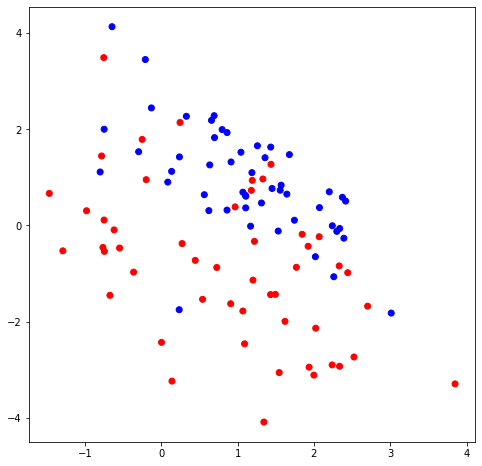

In [28]:
# сгенерируем данные: 100 объектов, 2 признака
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=52)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [29]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

### Сажаем лес

#### Сумничаем и призначаем

In [30]:
np.random.seed(12)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [31]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

#### Сажаем дерево

In [32]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [33]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [34]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [35]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [36]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [37]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [38]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)
    

#### Тут случайно начался случайный лес


In [39]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [46]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [47]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [48]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [49]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Строим различные леса


Вот тут надо взять тестовые лейблы и тестовые ансверы и заусунуть их в нужные мета. 

In [57]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Точность на обучающей выборке
train_answers = tree_vote(my_forest_1 , train_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_answers = tree_vote(my_forest_1 , test_data)
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 72.857
Точность случайного леса из 1 деревьев на тестовой выборке: 56.667
CPU times: user 11.9 ms, sys: 571 µs, total: 12.5 ms
Wall time: 16.7 ms


In [ ]:
##for i in range(len(train_labels)):
#  print(train_labels[i], train_answers[i])

In [58]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Точность на обучающей выборке
train_answers = tree_vote(my_forest_3 , train_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
train_answers = tree_vote(my_forest_3 , test_data)

print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

#for i in range(len(train_labels)):
#  print(train_labels[i], train_answers[i])

Точность случайного леса из 3 деревьев на обучающей выборке: 82.857
Точность случайного леса из 3 деревьев на тестовой выборке: 56.667
CPU times: user 33.3 ms, sys: 1.81 ms, total: 35.1 ms
Wall time: 39.9 ms


In [59]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Точность на обучающей выборке
train_answers = tree_vote(my_forest_10 , train_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
train_answers = tree_vote(my_forest_10 , test_data)

test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')


Точность случайного леса из 10 деревьев на обучающей выборке: 85.714
Точность случайного леса из 10 деревьев на тестовой выборке: 56.667
CPU times: user 66.6 ms, sys: 0 ns, total: 66.6 ms
Wall time: 68.6 ms


In [60]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Точность на обучающей выборке
train_answers = tree_vote(my_forest_50 , train_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
train_answers = tree_vote(my_forest_50 , test_data)

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 88.571
Точность случайного леса из 50 деревьев на тестовой выборке: 56.667
CPU times: user 294 ms, sys: 2.84 ms, total: 297 ms
Wall time: 298 ms


In [61]:
%%time
n_trees = 500
my_forest_500 = random_forest(train_data, train_labels, n_trees)

# Точность на обучающей выборке
train_answers = tree_vote(my_forest_500 , train_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
train_answers = tree_vote(my_forest_500 , test_data)

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 500 деревьев на обучающей выборке: 85.714
Точность случайного леса из 500 деревьев на тестовой выборке: 56.667
CPU times: user 3.08 s, sys: 11 ms, total: 3.09 s
Wall time: 3.1 s


### Визуализируем

In [67]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, forest):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

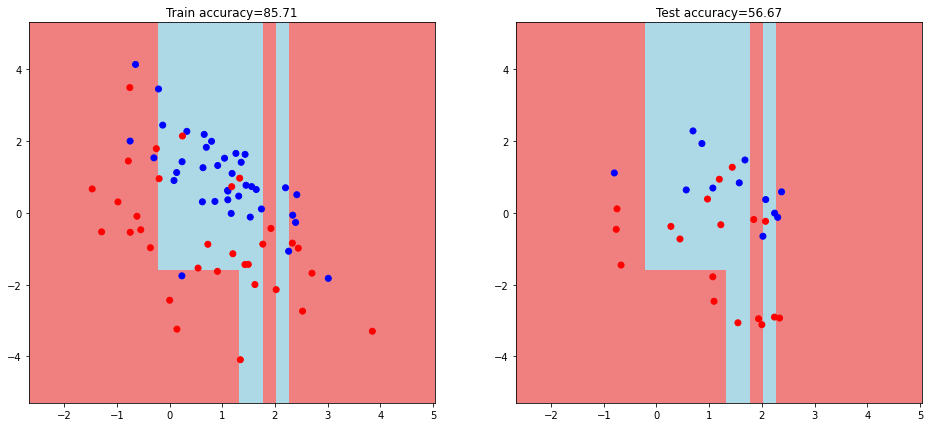

In [68]:
visualize(train_data, test_data, my_forest_1)

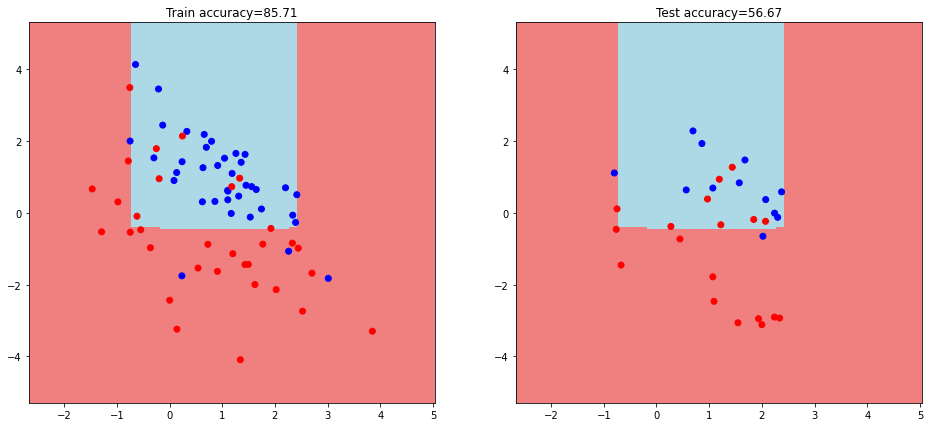

In [69]:
visualize(train_data, test_data, my_forest_3)

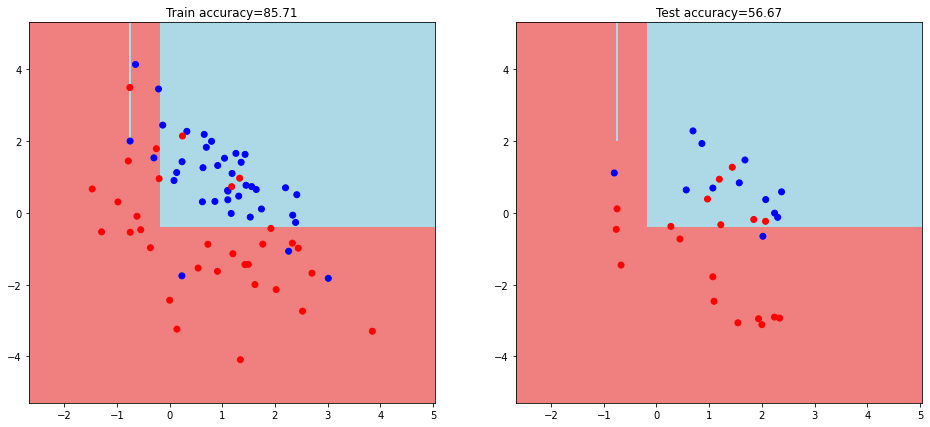

In [70]:
visualize(train_data, test_data, my_forest_10)

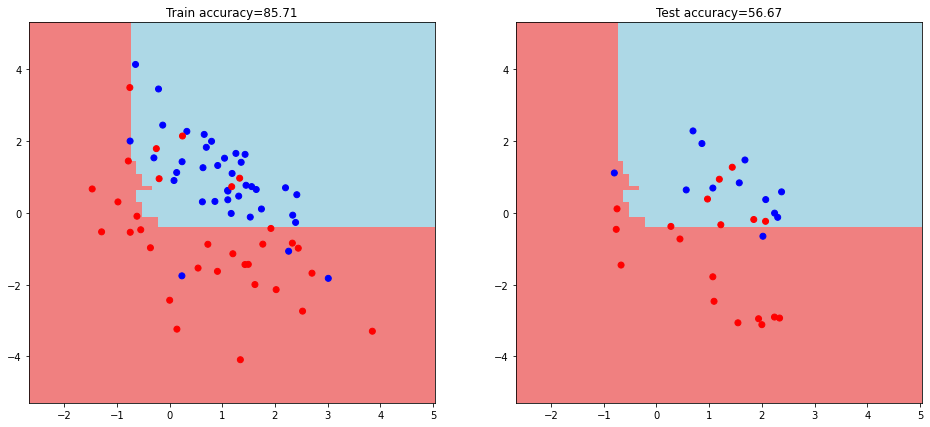

In [71]:
visualize(train_data, test_data, my_forest_50)

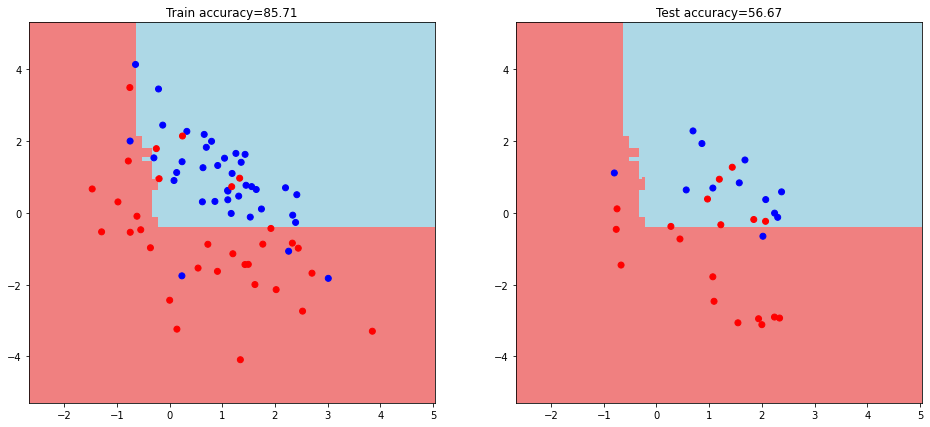

In [72]:
visualize(train_data, test_data, my_forest_500)

# Задание №4. *(На повторение) 
Переписать функцию `gini` из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в `entropy`.

## Рассчет энтропии Шенона


Энтропийный критерийили Шеннона вычисляется по формуле :

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$
 
Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$


In [110]:
# Расчет энтропии Шенона

def entropy (labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p*np.log2(p)

    return impurity

## Строим дерево и проверяем все

In [111]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [112]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [156]:
# Расчет прироста

def gain(left_labels, right_labels, root_entropy):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [157]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [158]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    root_entropy = entropy(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)           
            current_gain = gain(true_labels, false_labels, root_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [159]:
#Подсчет количества листов в ноде
def leafs_count(node):
    ls = 0
    if isinstance(node, Leaf):
        ls = ls + 1
        return ls
    ls = ls + leafs_count(node.true_branch) 
    ls = ls + leafs_count(node.false_branch)
    return ls

In [160]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, el_count, leafs):

    gain, t, index = find_best_split(data, labels)

    #Если возможно создать меньше двух лстов, то останавливаем дерелени
    if leafs < 2:
      return Leaf(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
      return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    #Если в результате разбиения количесто элементов меньше требуемого для листа, то новая ветка не генерится
    if true_data.shape[0] <= el_count or false_data.shape[0] <= el_count: 
      return Leaf(data, labels)
    
    # Рекурсивно строим два поддерева 
    # Резервируем один элемент для False ветки, на случай, если все все литы съест Trut ветка
    true_branch = build_tree(true_data, true_labels, el_count, leafs - 1)

    #уменьшаем количество доступных листов узла на количество листов в true ветке 
    leafs = leafs - leafs_count(true_branch)

    false_branch = build_tree(false_data, false_labels, el_count, leafs)
   
    #уменьшаем количество доступных листов узла на количество листов в false ветке 
    leafs = leafs - leafs_count(false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева

    return Node(index, t, true_branch, false_branch)

In [161]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [162]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

## Проверка

In [163]:
# сгенерируем данные 
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=8, n_samples = 300)

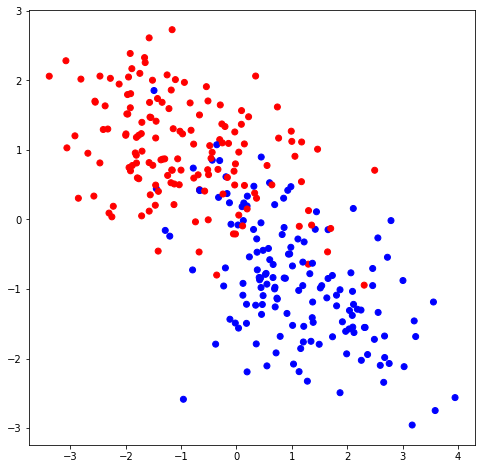

In [164]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [165]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [166]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=''):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '> True:')
    print_tree(node.true_branch, spacing + "-")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '> False:')
    print_tree(node.false_branch, spacing + "-")
    

In [169]:
my_tree = build_tree(train_data, train_labels, 1, leafs = 120)
print_tree(my_tree)

Индекс 1 <= -0.141661458578085
> True:
-Индекс 0 <= -0.018630610158921423
-> True:
--Индекс 1 <= -0.9569842761342535
--> True:
---Прогноз: 1
--> False:
---Индекс 0 <= -0.2005212534456169
---> True:
----Индекс 1 <= -0.4549835526402539
----> True:
-----Прогноз: 0
----> False:
-----Прогноз: 1
---> False:
----Прогноз: 0
-> False:
--Прогноз: 1
> False:
-Индекс 1 <= 0.4438395953160996
-> True:
--Индекс 0 <= -1.4673110925503379
--> True:
---Прогноз: 0
--> False:
---Индекс 1 <= 0.15117421125794617
---> True:
----Прогноз: 0
---> False:
----Индекс 1 <= 0.2131684366195017
----> True:
-----Прогноз: 1
----> False:
-----Индекс 1 <= 0.4081613085132725
-----> True:
------Индекс 1 <= 0.3174106533505816
------> True:
-------Прогноз: 0
------> False:
-------Прогноз: 0
-----> False:
------Индекс 0 <= -0.6685578007404154
------> True:
-------Прогноз: 1
------> False:
-------Прогноз: 1
-> False:
--Индекс 0 <= -1.5127086776937262
--> True:
---Прогноз: 0
--> False:
---Индекс 0 <= -0.19035531777562698
---> Tru

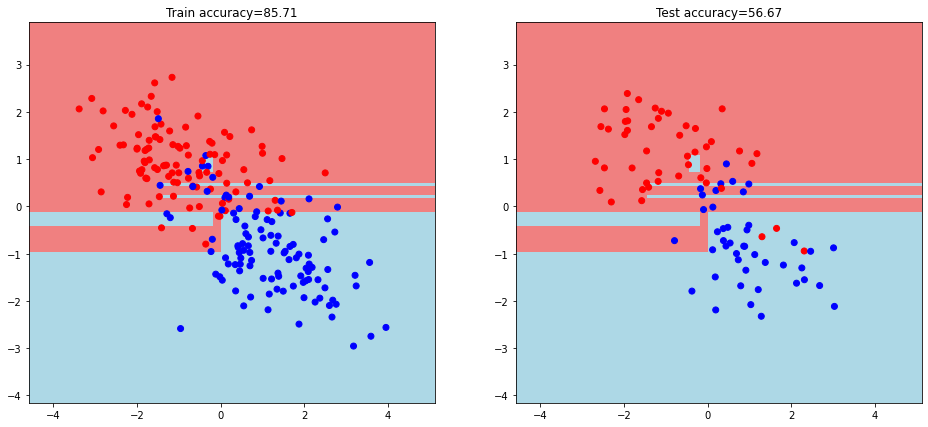

In [170]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

visualize(train_data, test_data)